In [140]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns


In [141]:
entire_df = pd.read_csv('data.csv') # Load the file
entire_df.head() # check the first few rows, to see if it has laoded correctly

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Split the data

In [142]:
train, test = train_test_split(entire_df, train_size=0.7, random_state=42)
train, validation = train_test_split(train, train_size=0.7, random_state=42)

In [143]:
print(train.shape, validation.shape, test.shape) # check if it is correct

(3341, 96) (1432, 96) (2046, 96)


## DEV TEAM

In [144]:
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0:1]
y_train = y_train.values.ravel() # flattens the df to 1-dim array


x_val = validation.iloc[:, 1:]
y_val = validation.iloc[:, 0:1]
y_val = validation.values.ravel() # flattens the df to 1-dim array
y_val = validation.iloc[:, 0].values.ravel()

df_x = x_val
df_y = y_val

In [162]:
def filter_data(input_df, train_x_df): # Applies the same changes for multiple df
    threshold = 0.00 # Selecting the variance threshold - very low
    sel = VarianceThreshold(threshold=threshold)
    transformed_features = sel.fit_transform(train_x_df)
    selected_columns = sel.get_support(indices=True)
    selected_columns = input_df.columns[selected_columns]
    selected_df = input_df[selected_columns]
    selected_df # df with the low variance columns removed
    return selected_df

In [163]:
def replace_outliers_with_iqr(df):
    df_copy = df.copy()  # Stwórz kopię ramki danych, aby uniknąć modyfikacji oryginalnej ramki danych
    for col in df_copy.columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Zastępowanie outlierów medianą kolumny
        df_copy.loc[(df_copy[col] < lower_bound) | (df_copy[col] > upper_bound), col] = df_copy[col].median()
    
    return df_copy

In [164]:
def normalize_data(input_df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(input_df)
    normalized_df = pd.DataFrame(normalized_data, columns=input_df.columns)
    return normalized_df

In [165]:
def calculate_metrics(actual, predictions):
    """
    as actual use the real data, as predictions use the predicted values
    
    Helper func. to calculate multiple scores
    """
    ## Compute accuracy
    #accuracy = accuracy_score(actual, predictions)

    ## Compute precision
    #precision = precision_score(actual, predictions, zero_division='warn')

    ## Compute recall
    #recall = recall_score(actual, predictions)

    ## Compute F1-score
    ##f1 = f1_score(actual, predictions)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(fpr, tpr)

    ## Print all the metrics
    #print("Accuracy:", accuracy)
    #print("Precision:", precision)
    #print("Recall:", recall)
    #print("F1-score:", f1)
    print("ROC AUC score:", roc_auc)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Compute confusion matrix
    #cm = confusion_matrix(actual, predictions)

    ## Plot confusion matrix
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn", cbar=False)
    #plt.xlabel('Predicted')
    #plt.ylabel('Actual')
    #plt.title('Confusion Matrix')
    #plt.show()


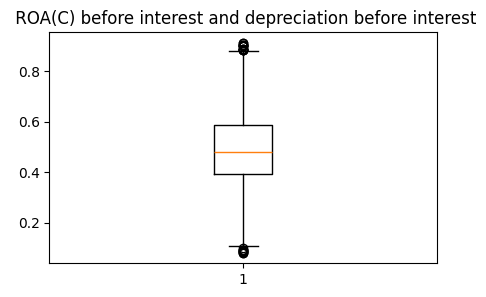

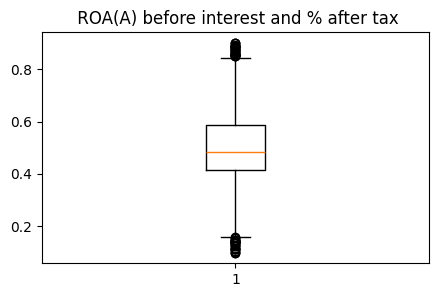

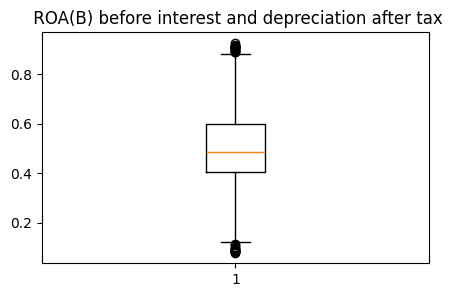

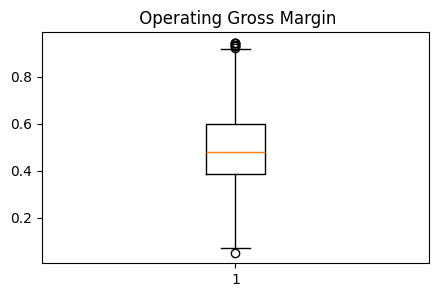

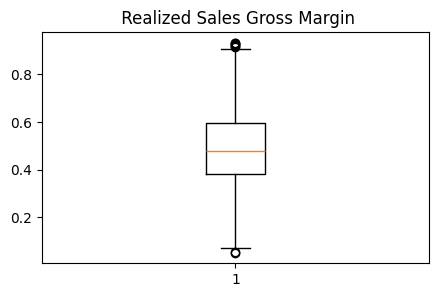

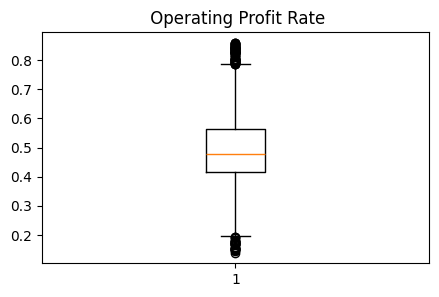

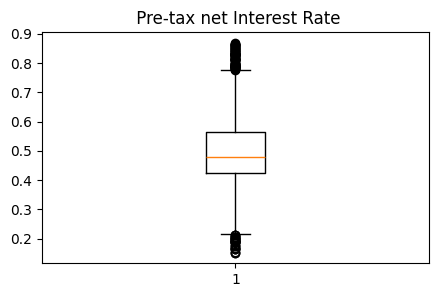

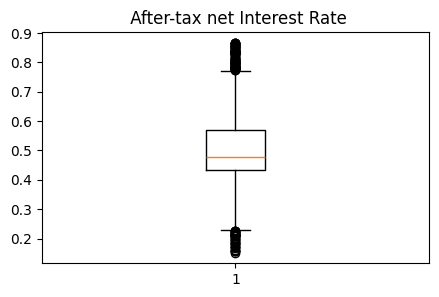

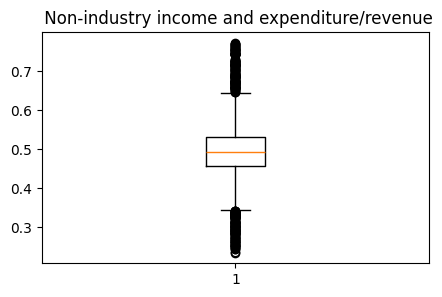

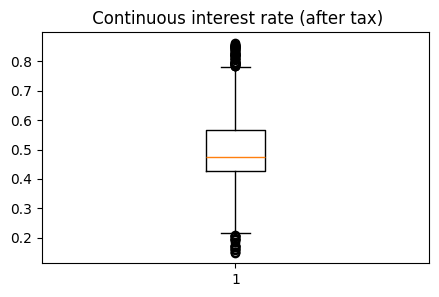

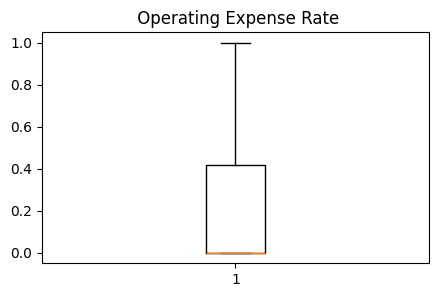

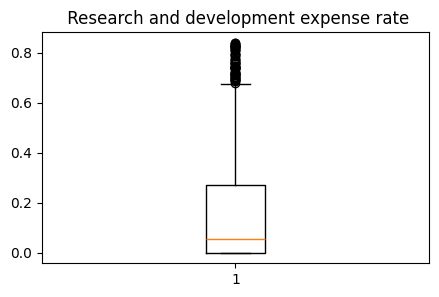

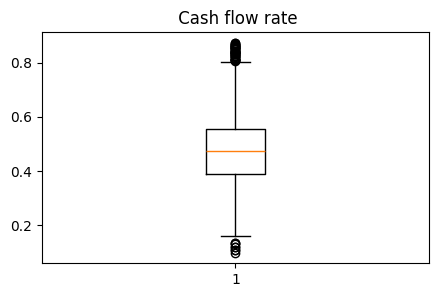

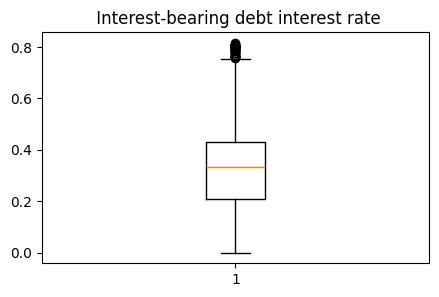

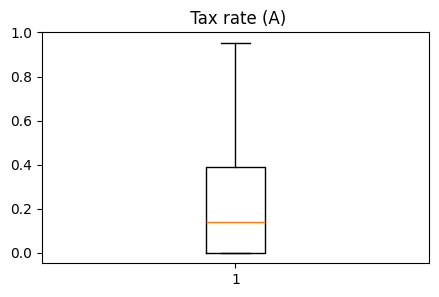

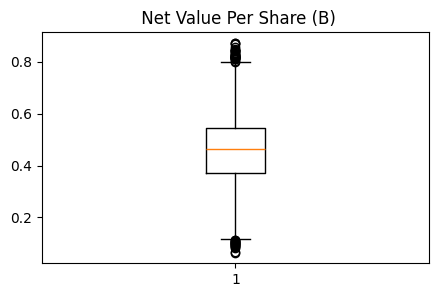

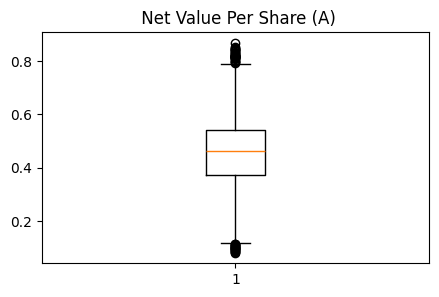

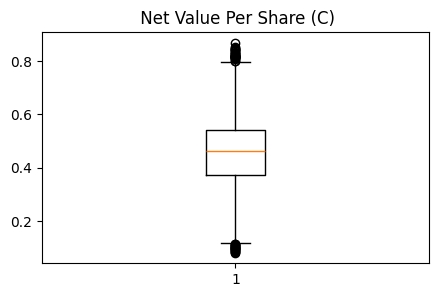

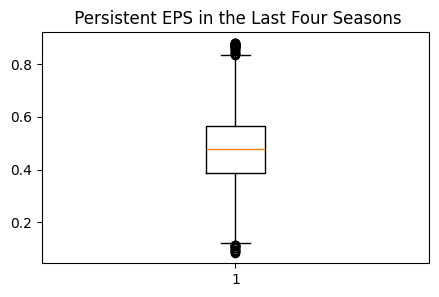

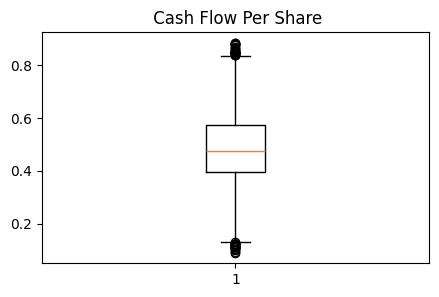

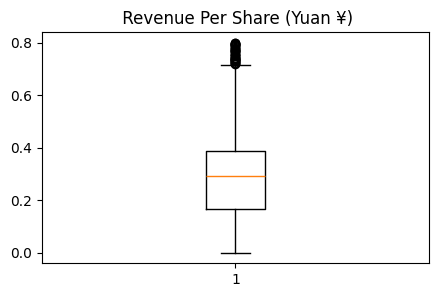

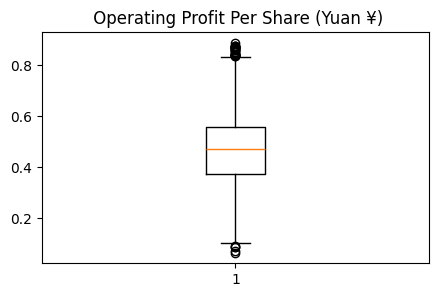

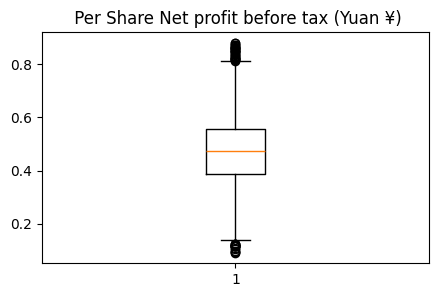

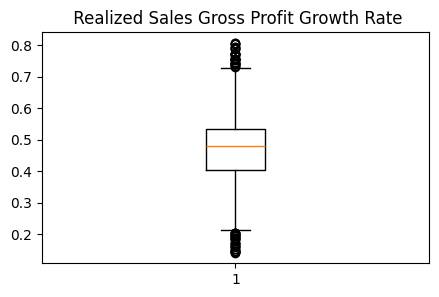

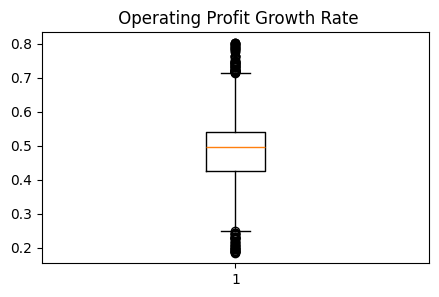

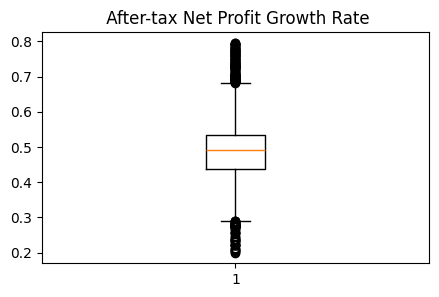

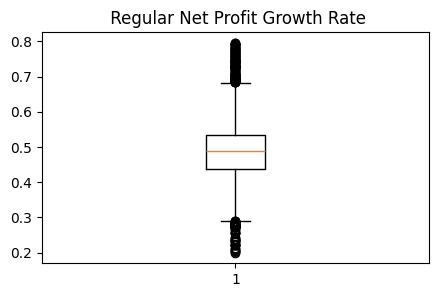

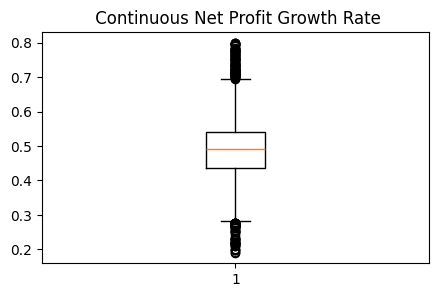

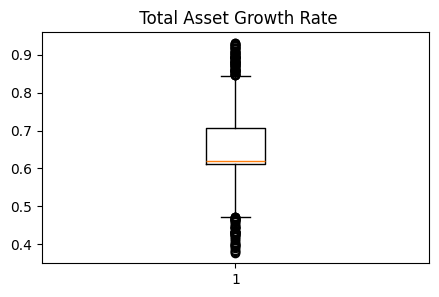

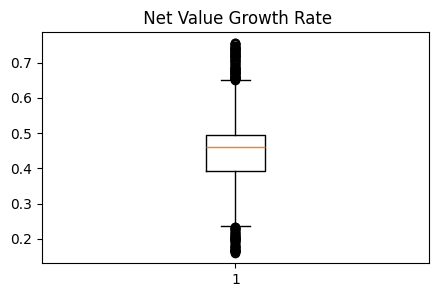

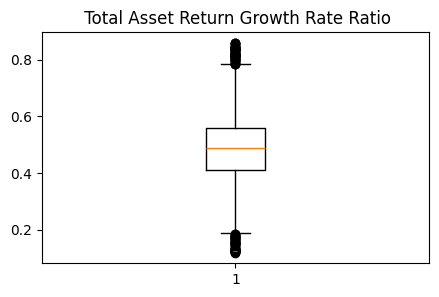

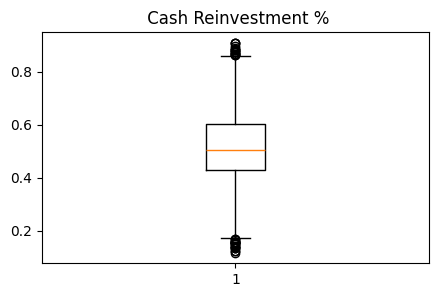

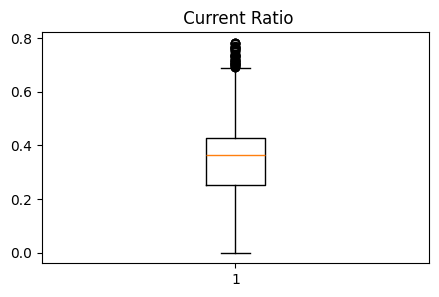

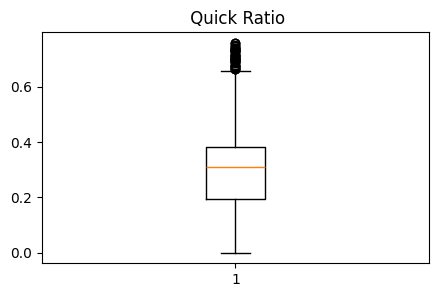

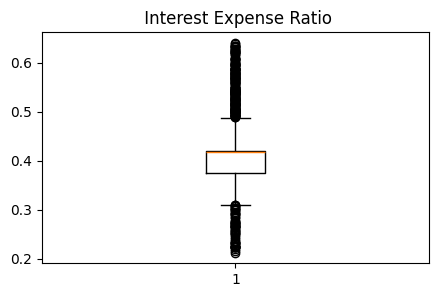

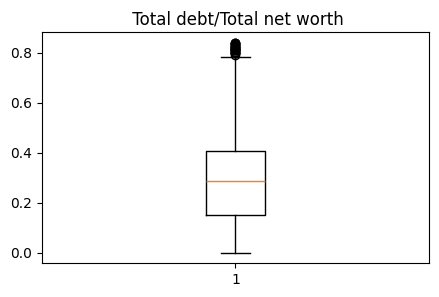

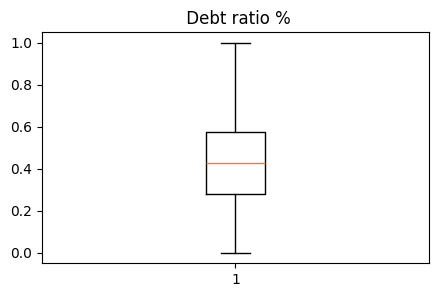

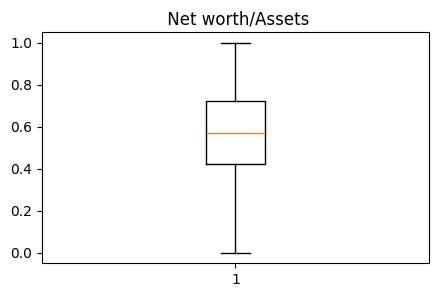

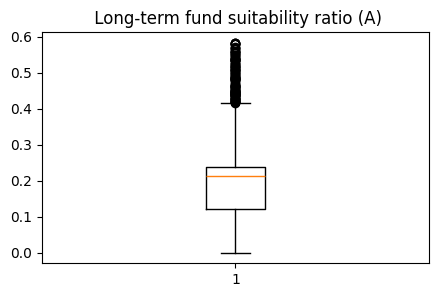

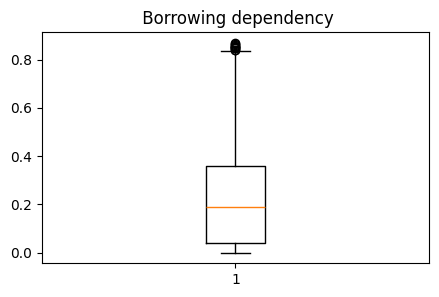

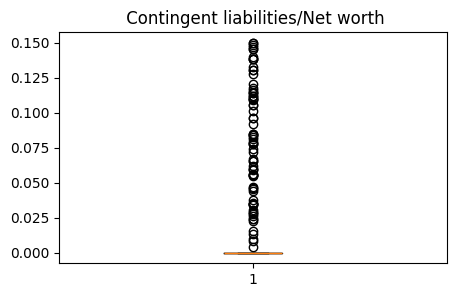

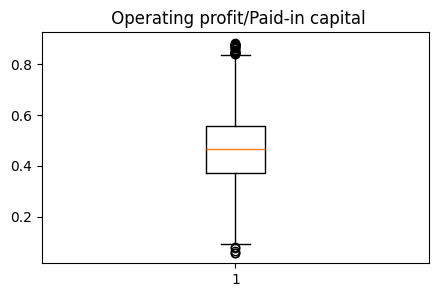

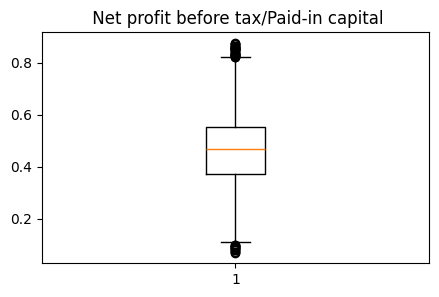

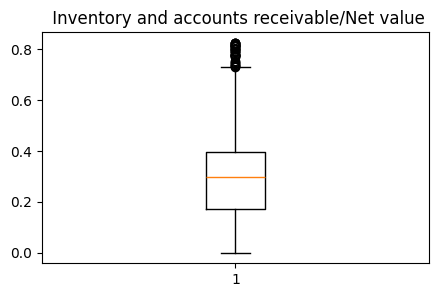

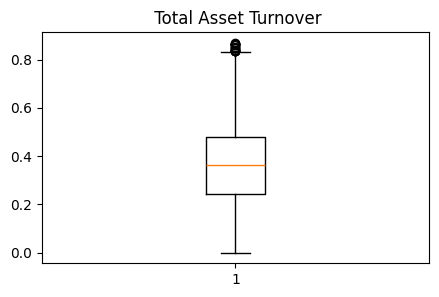

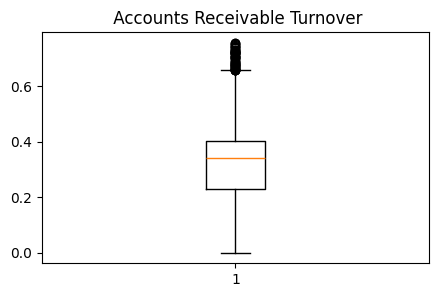

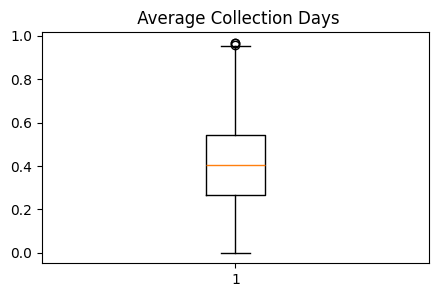

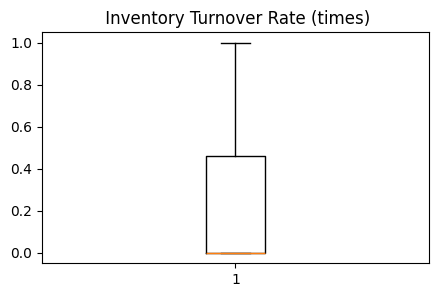

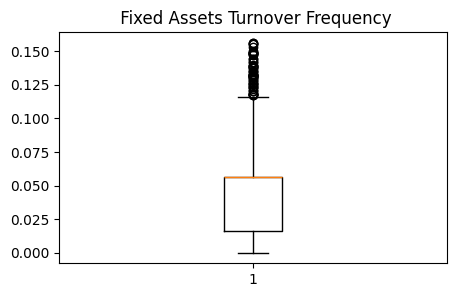

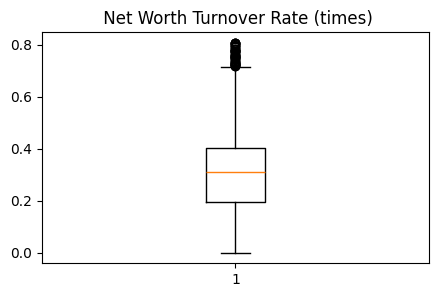

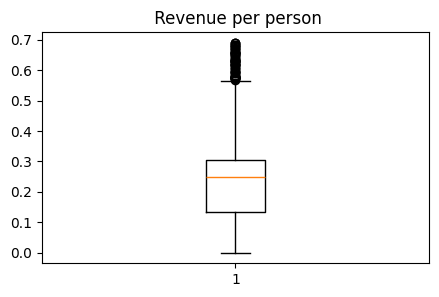

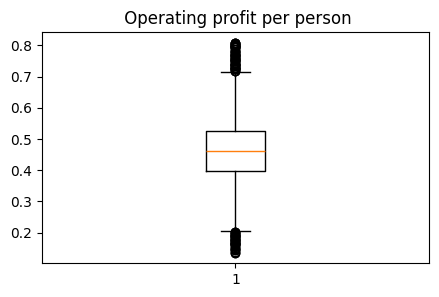

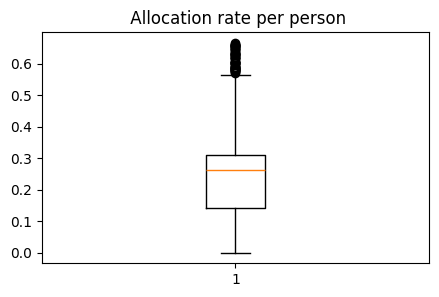

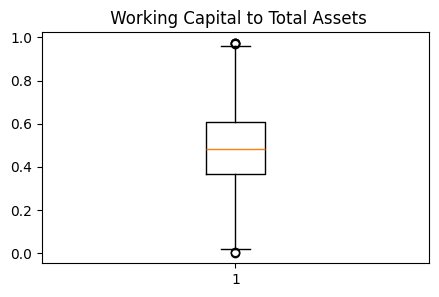

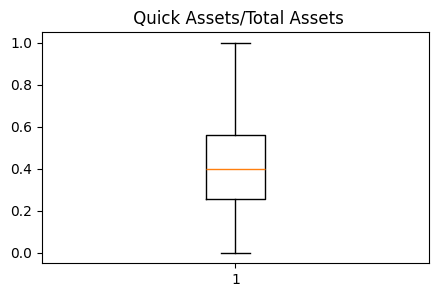

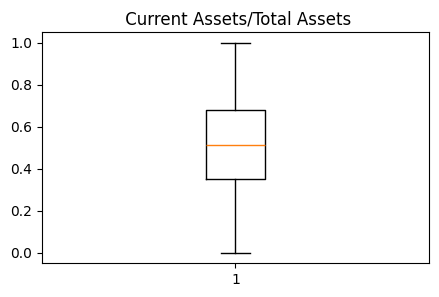

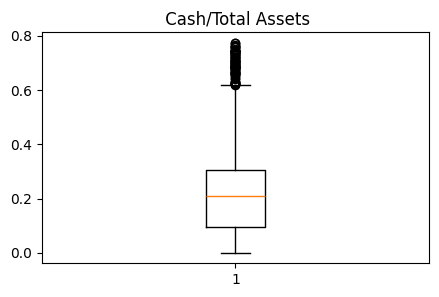

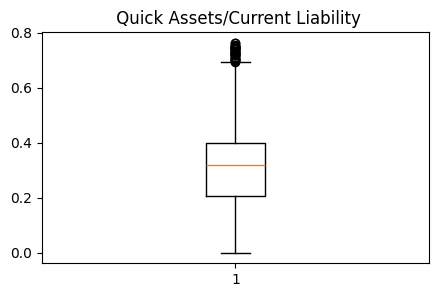

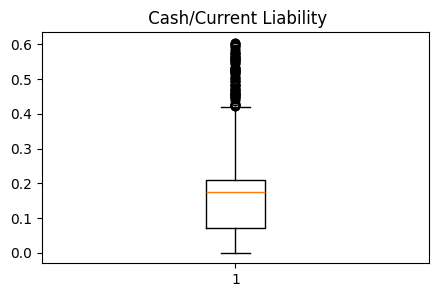

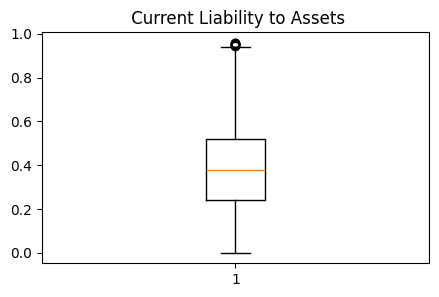

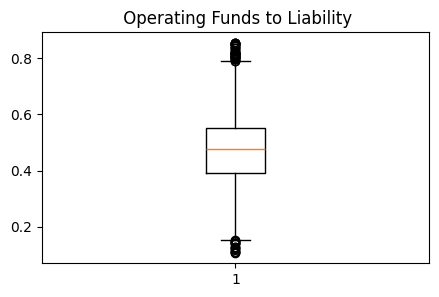

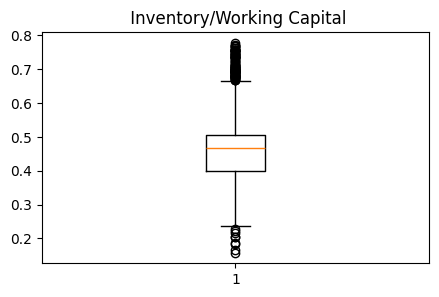

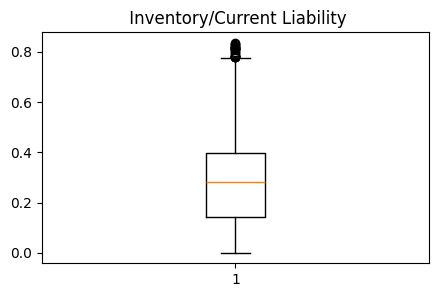

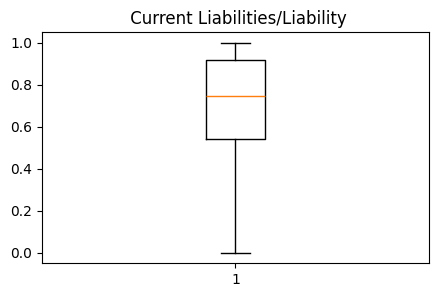

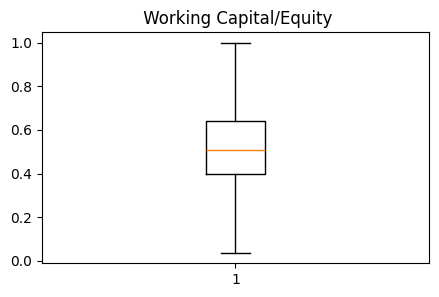

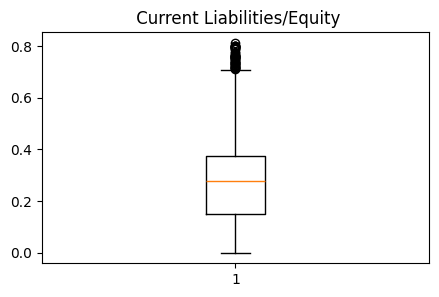

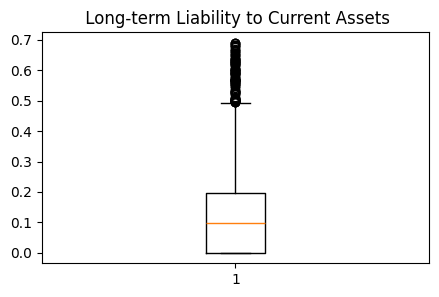

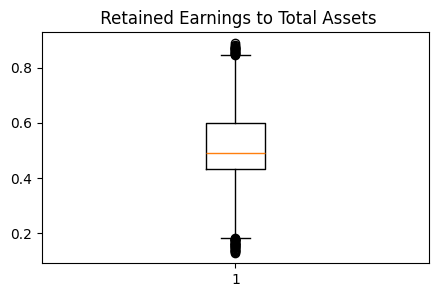

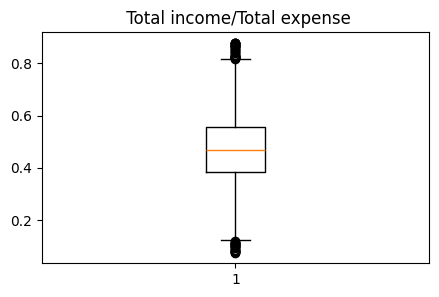

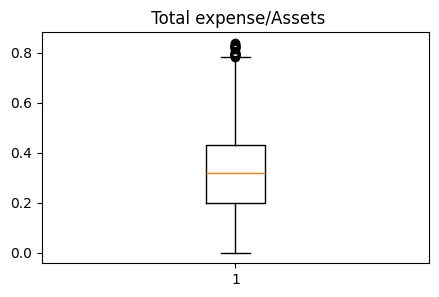

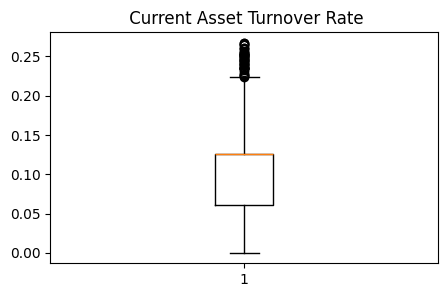

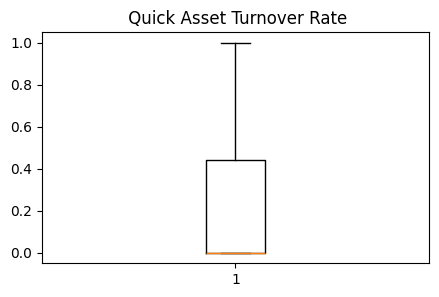

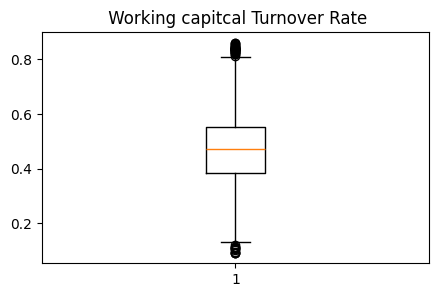

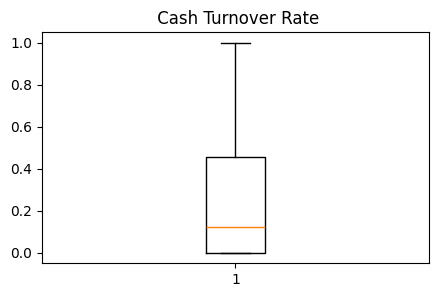

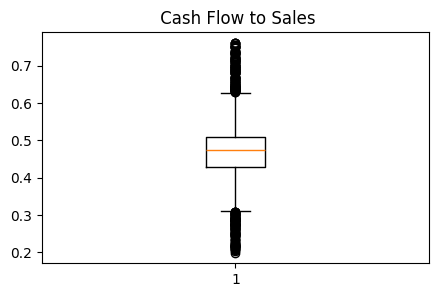

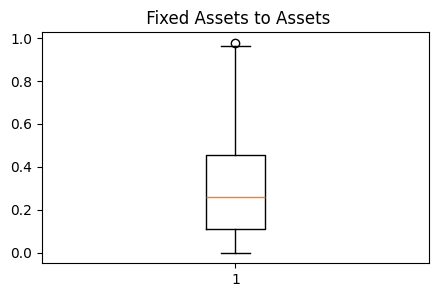

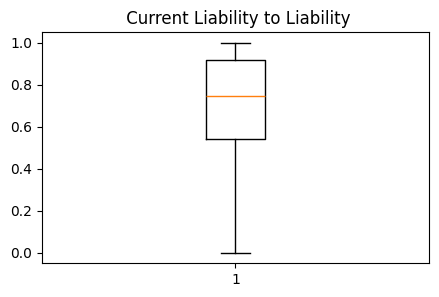

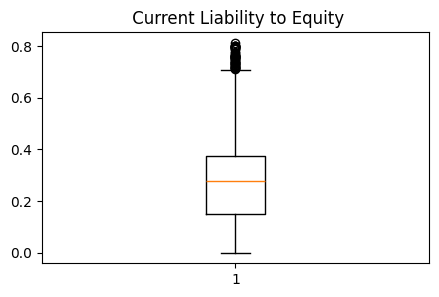

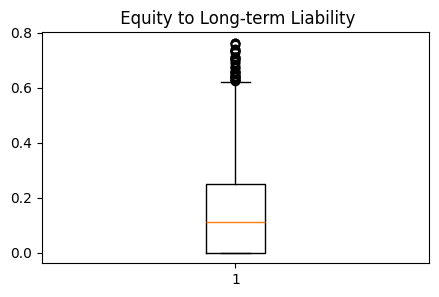

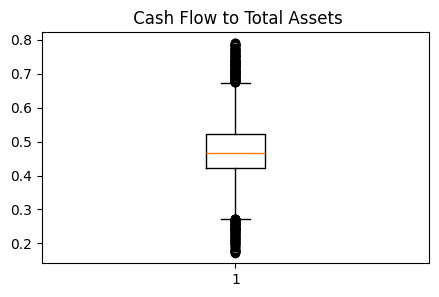

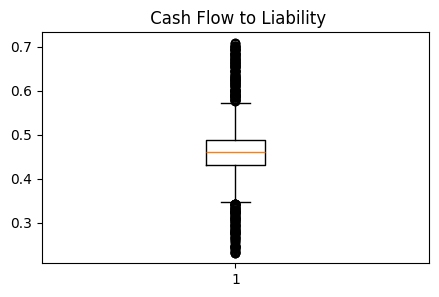

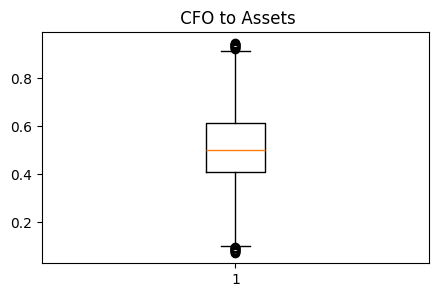

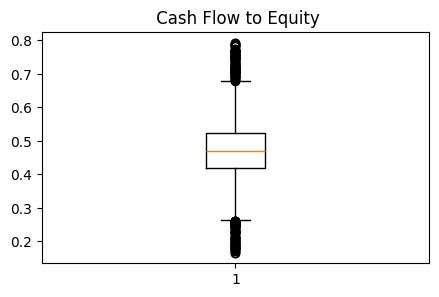

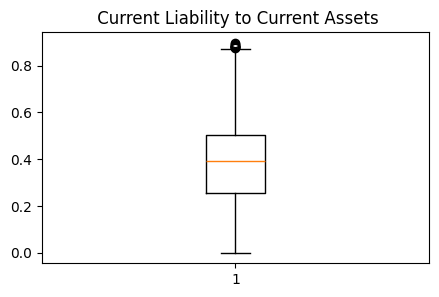

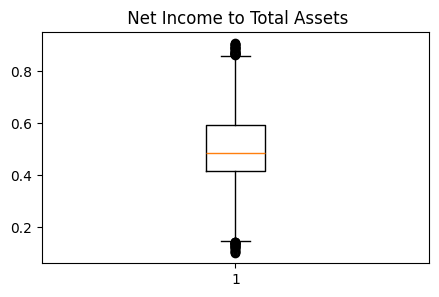

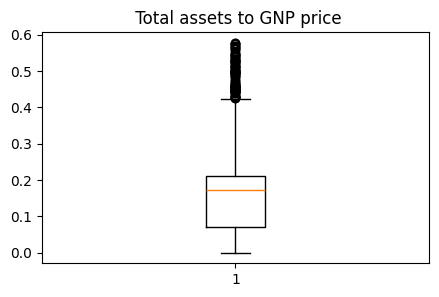

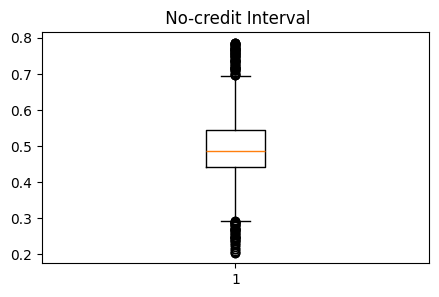

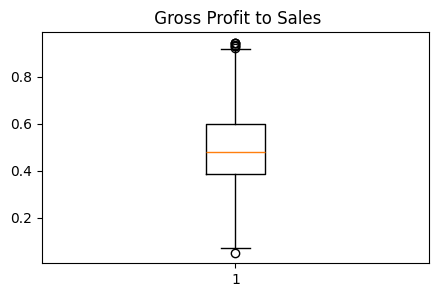

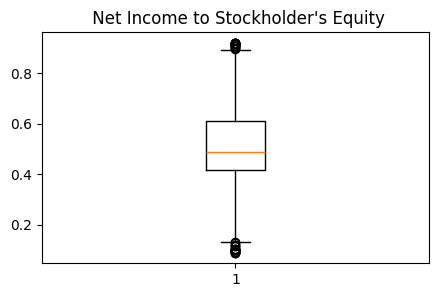

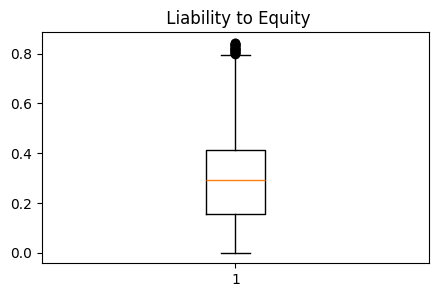

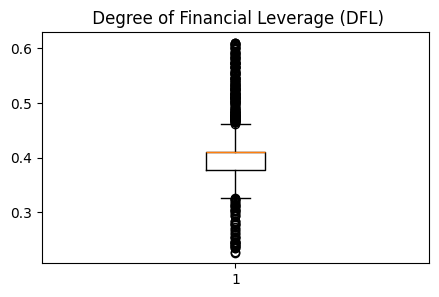

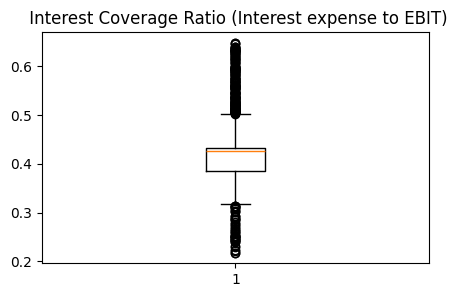

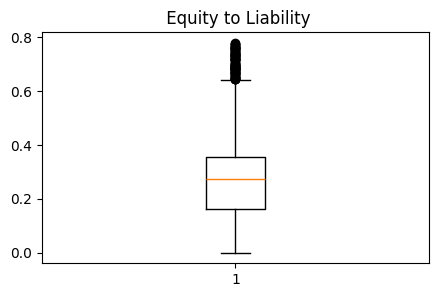

In [166]:
for column in df_x.columns:
    plt.figure(figsize=(5, 3))  # Rozmiar każdego wykresu
    plt.boxplot(df_x[column])  # Rysowanie wykresu pudełkowego dla konkretnej zmiennej
    plt.title(column)  # Tytuł wykresu
    plt.show()

In [167]:
df_x = filter_data(df_x, x_train)
x_train = filter_data(x_train, x_train)
df_x = replace_outliers_with_iqr(df_x)
x_train = replace_outliers_with_iqr(x_train)

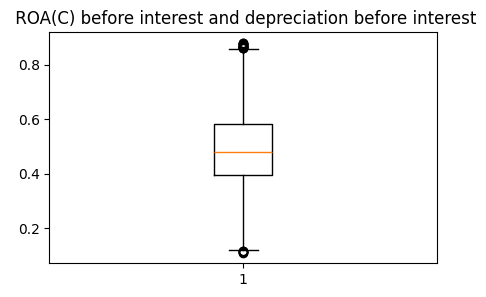

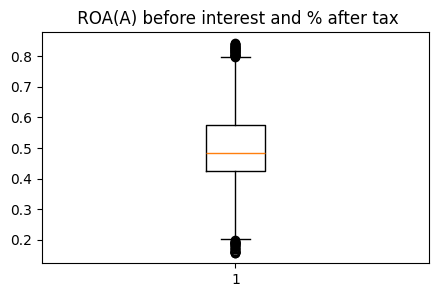

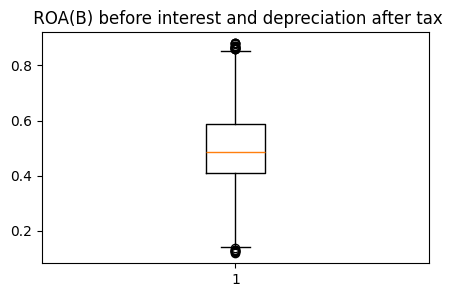

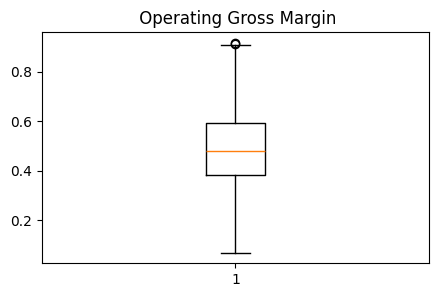

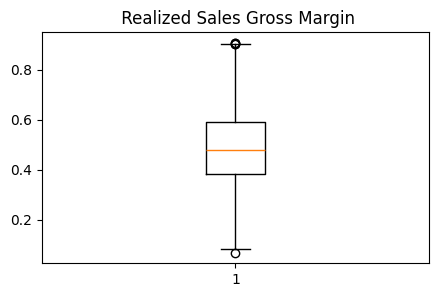

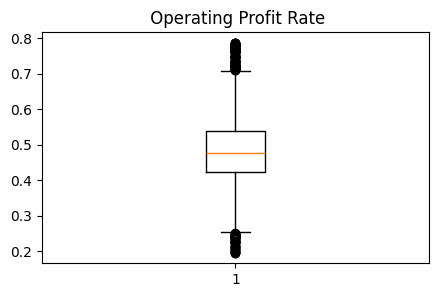

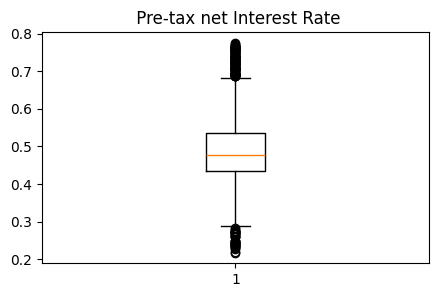

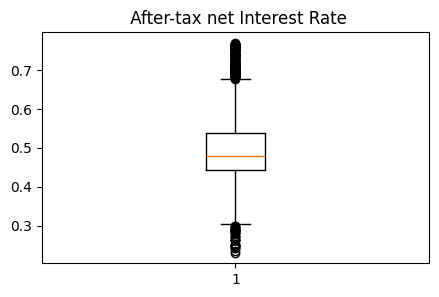

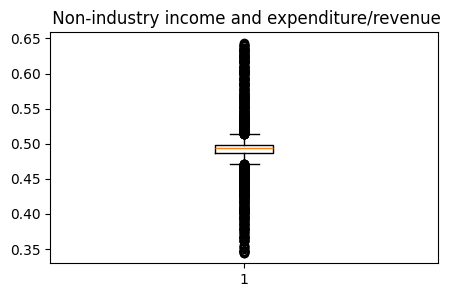

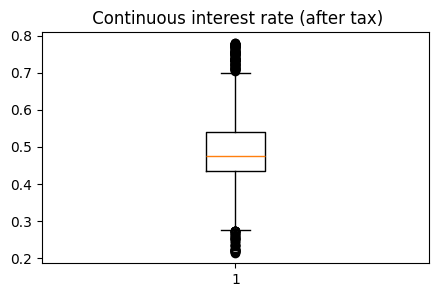

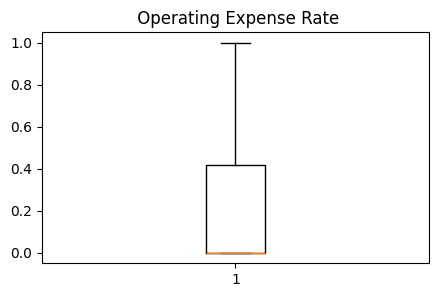

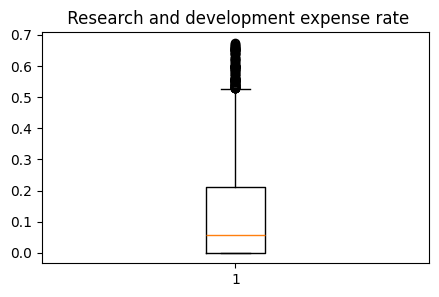

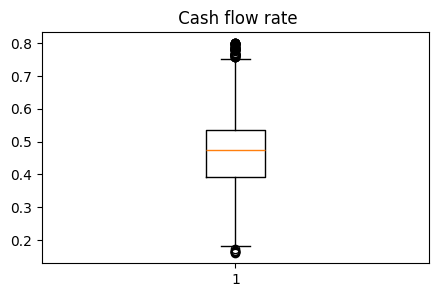

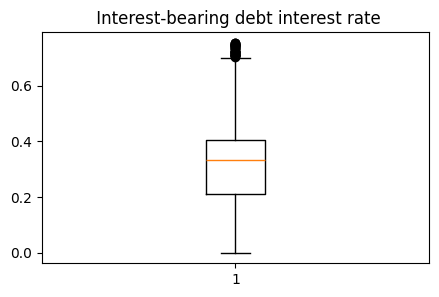

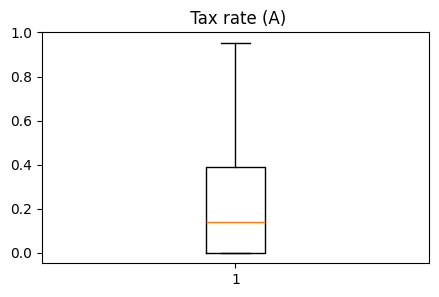

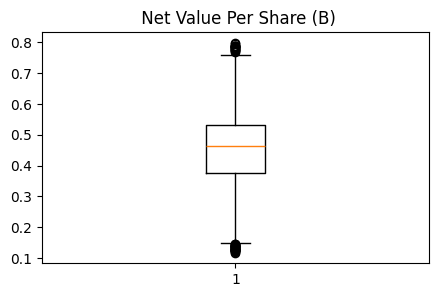

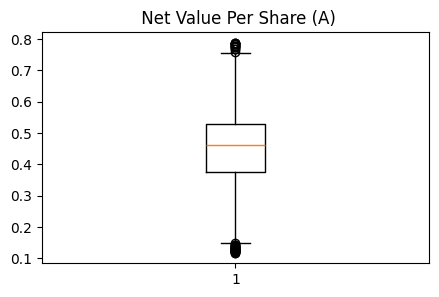

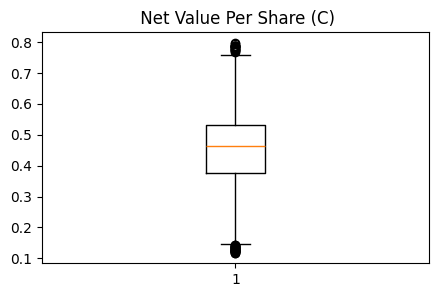

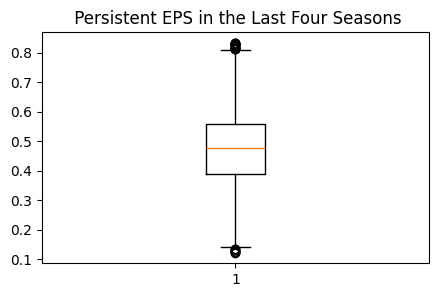

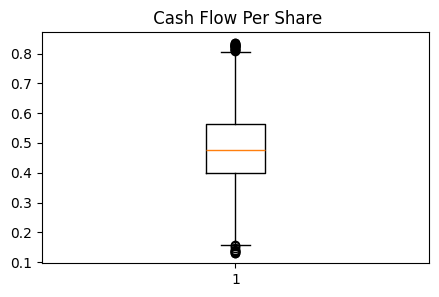

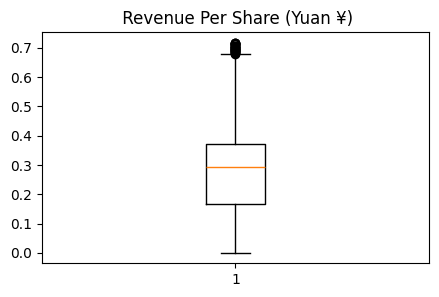

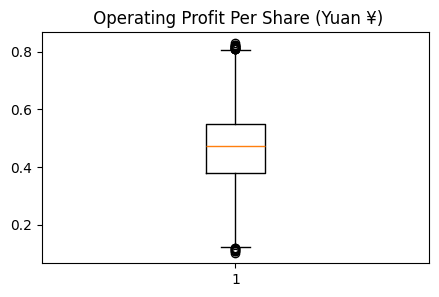

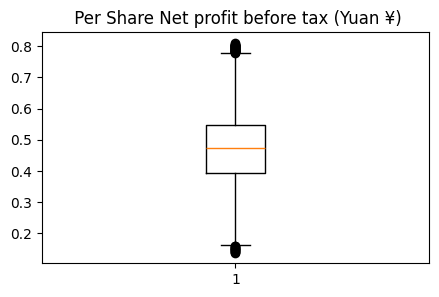

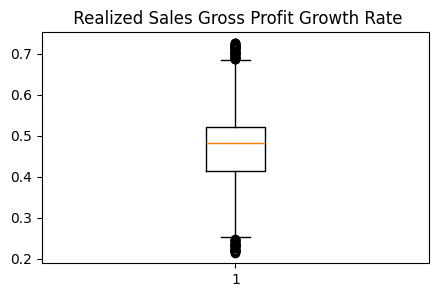

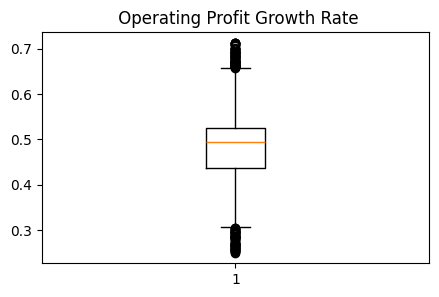

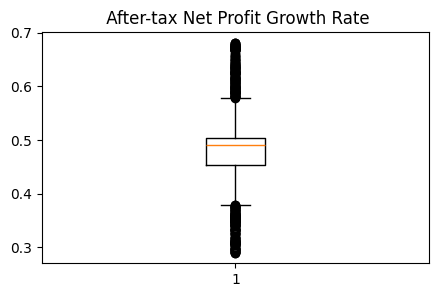

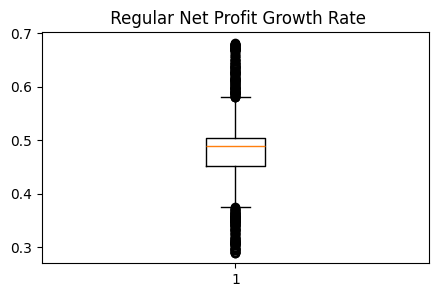

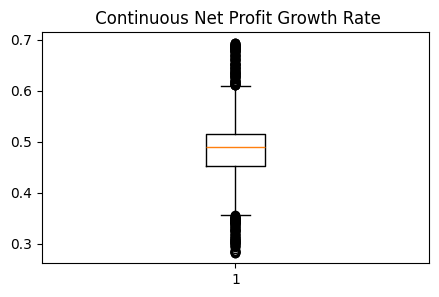

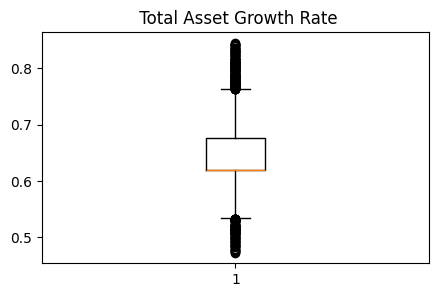

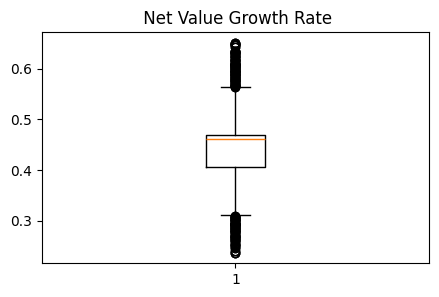

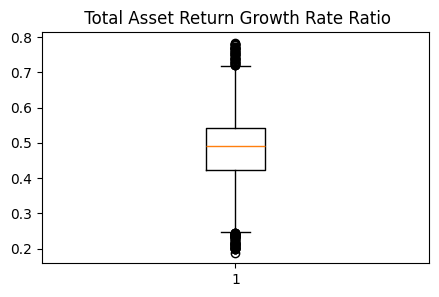

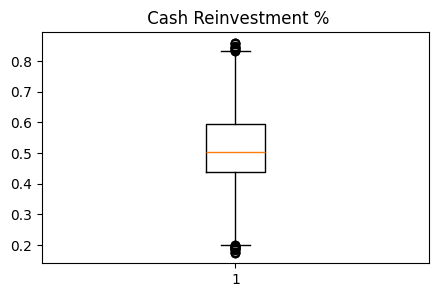

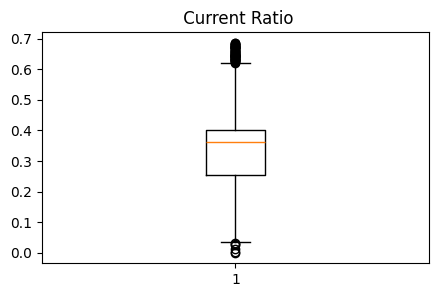

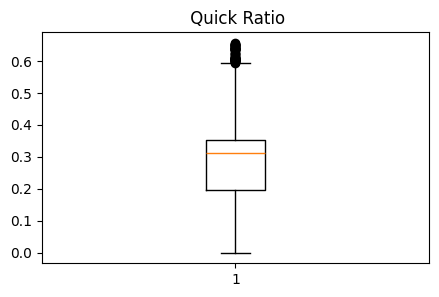

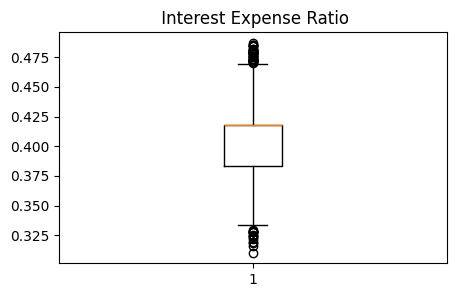

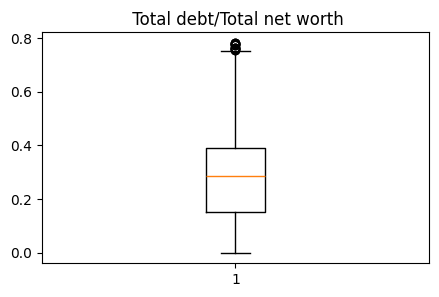

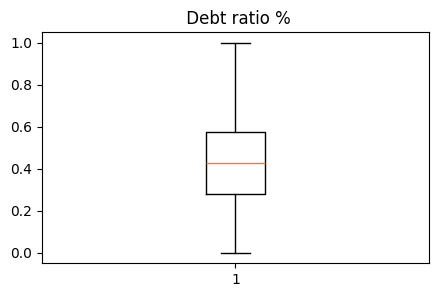

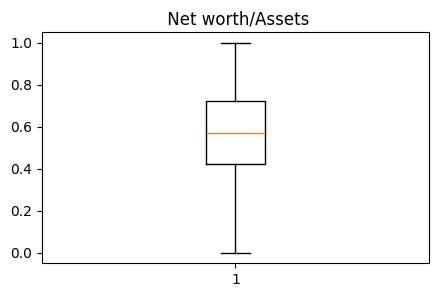

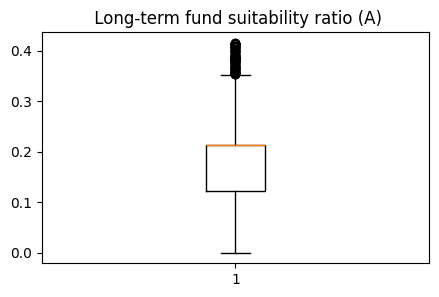

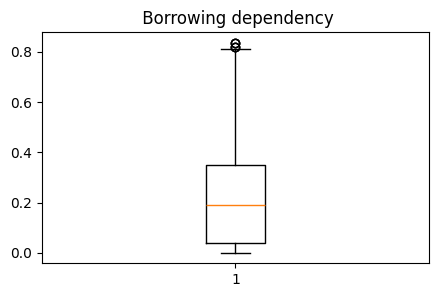

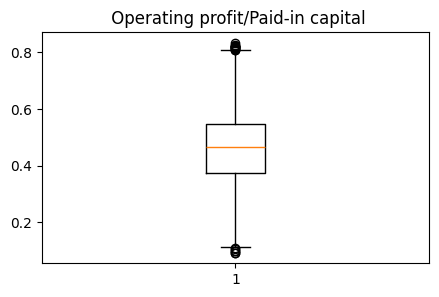

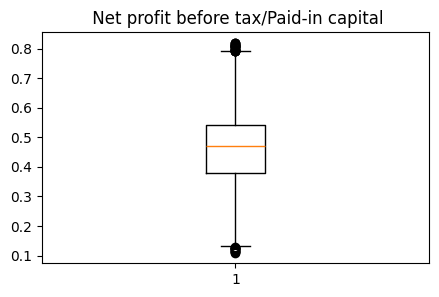

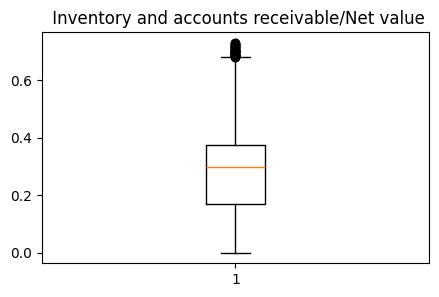

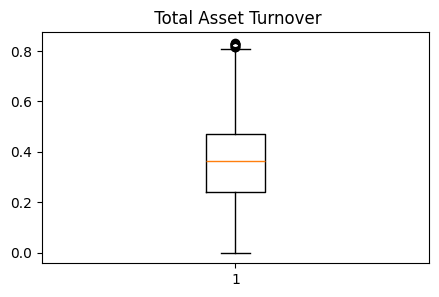

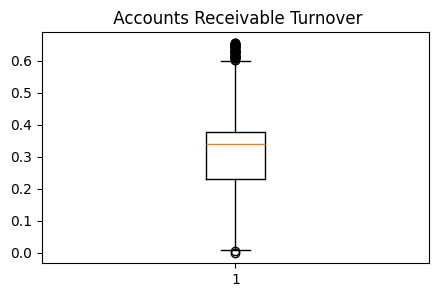

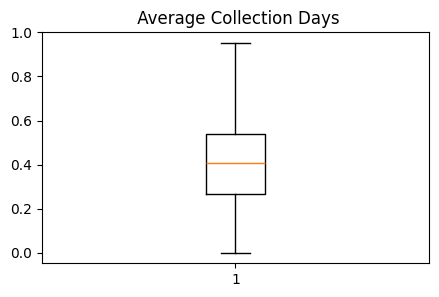

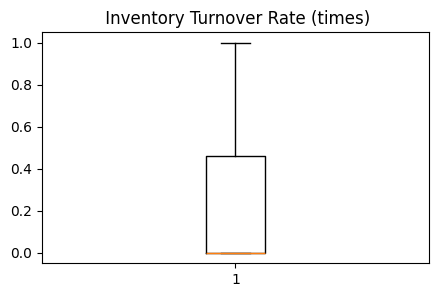

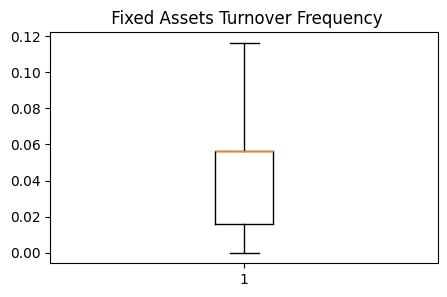

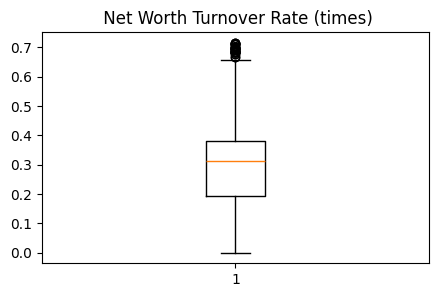

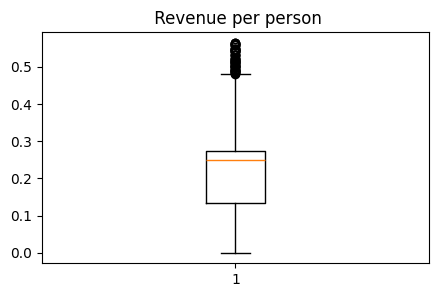

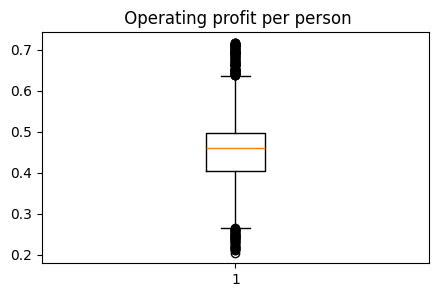

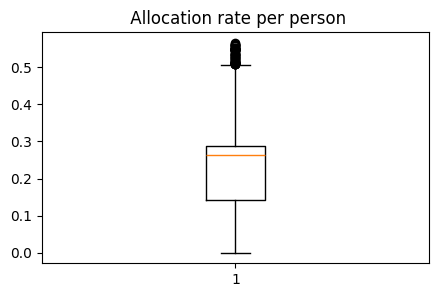

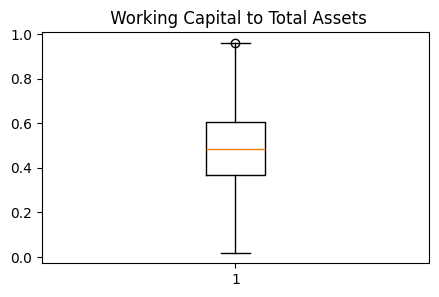

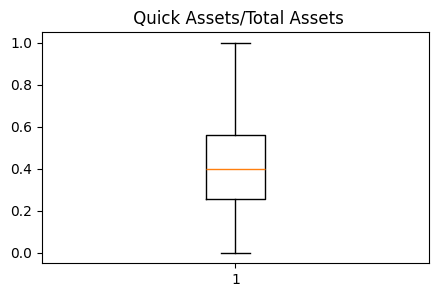

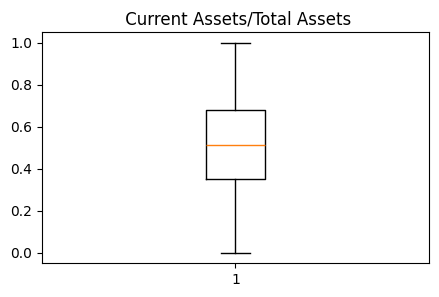

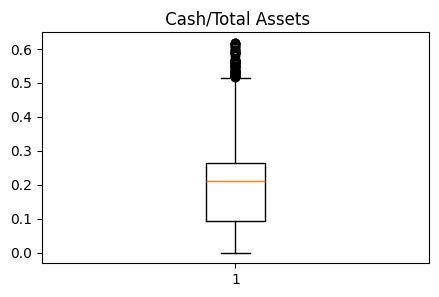

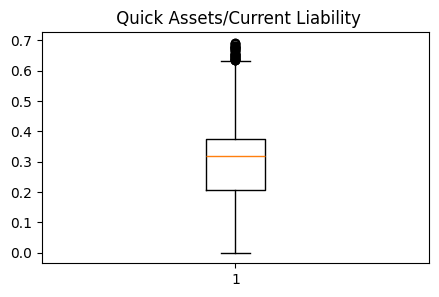

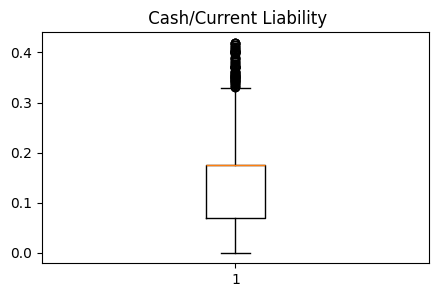

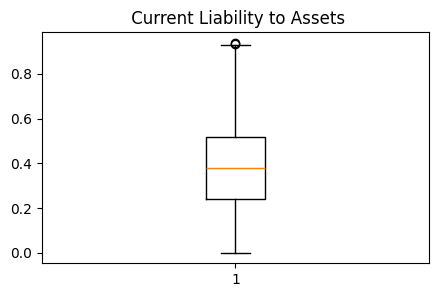

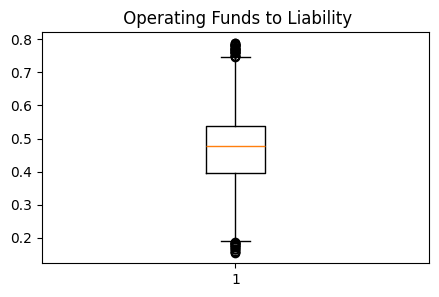

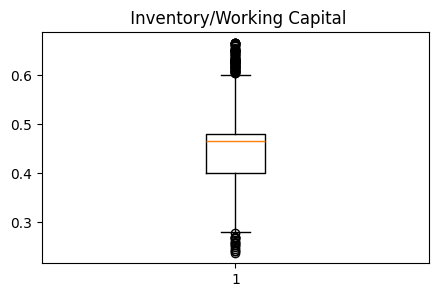

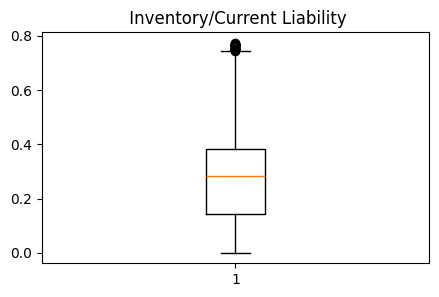

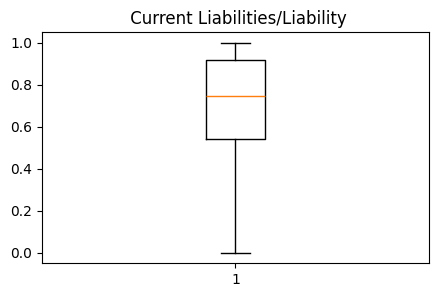

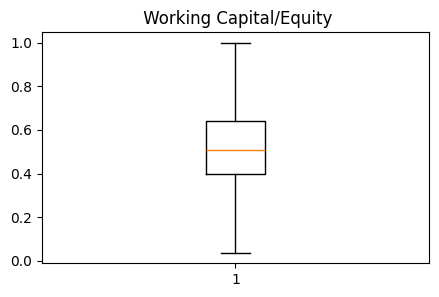

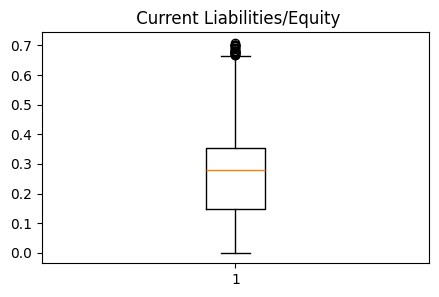

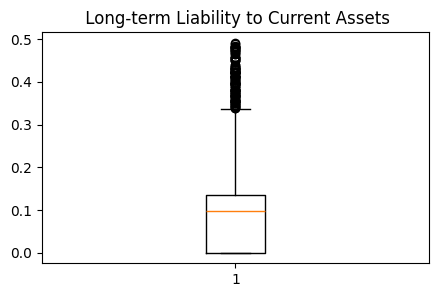

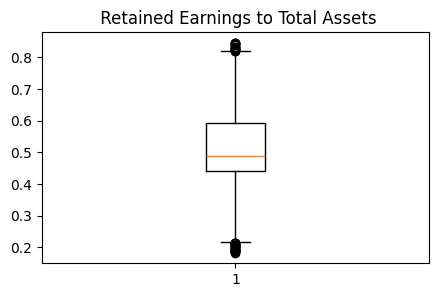

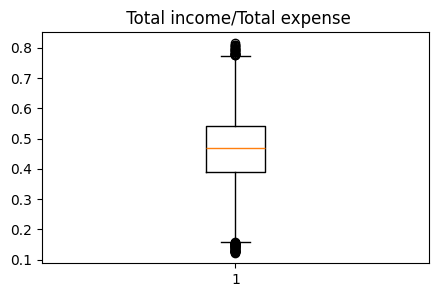

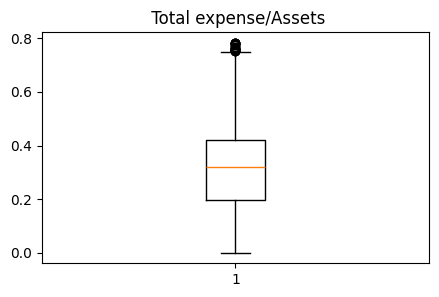

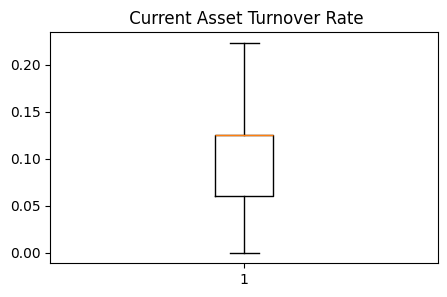

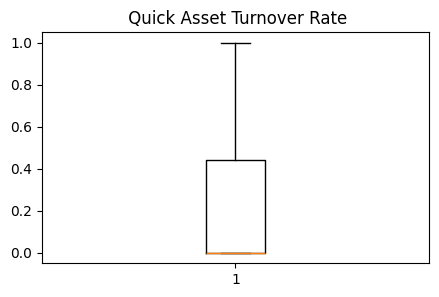

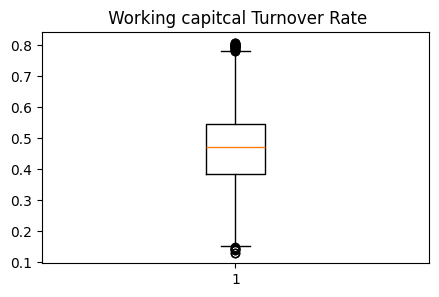

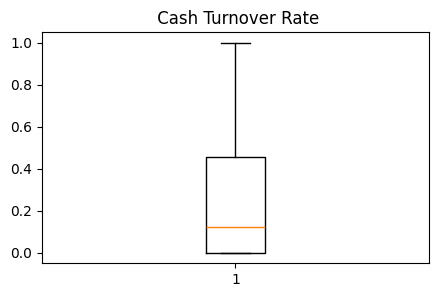

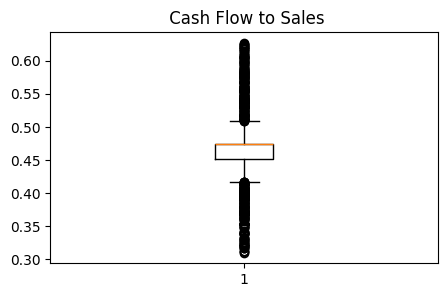

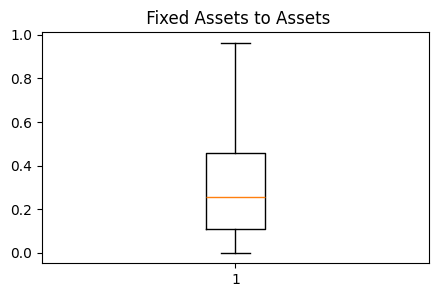

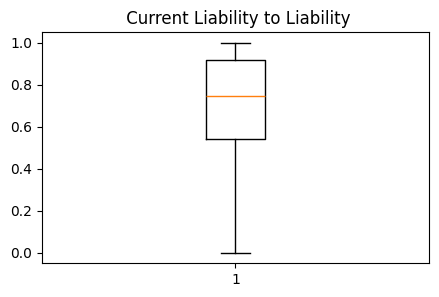

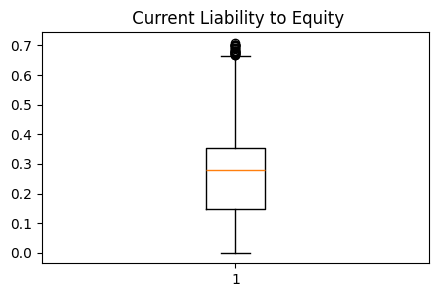

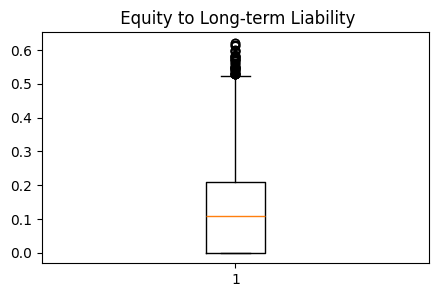

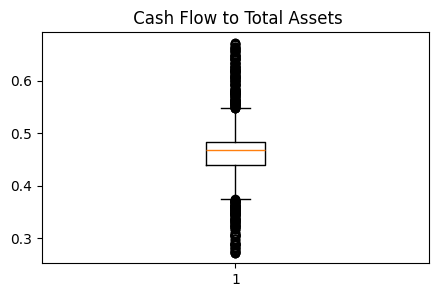

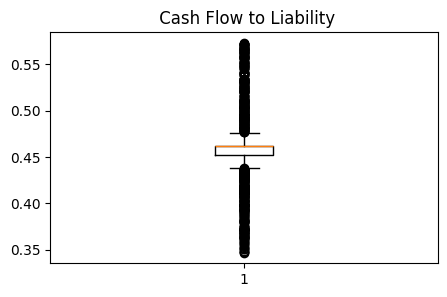

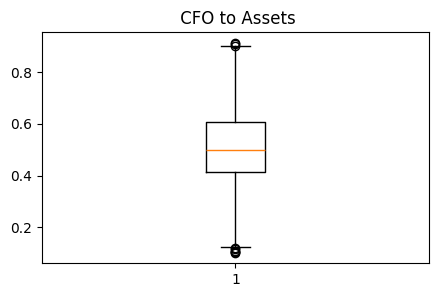

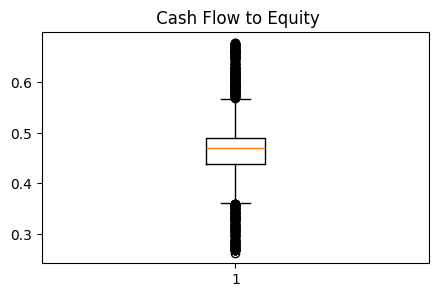

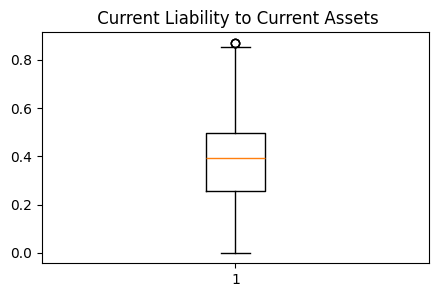

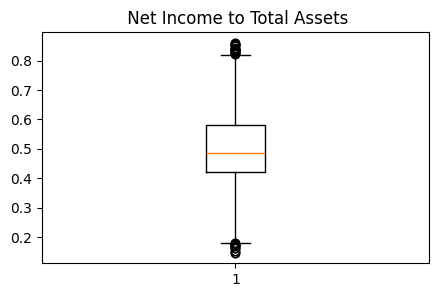

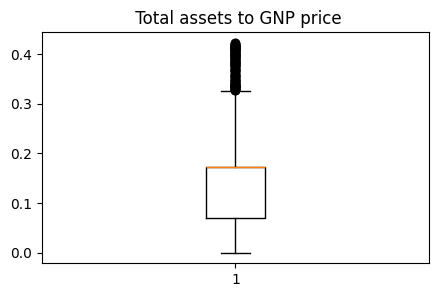

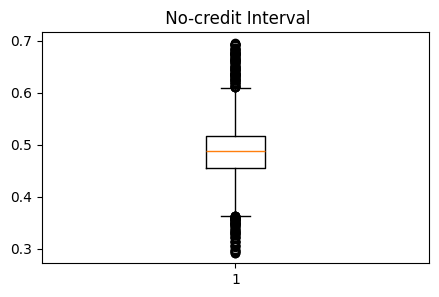

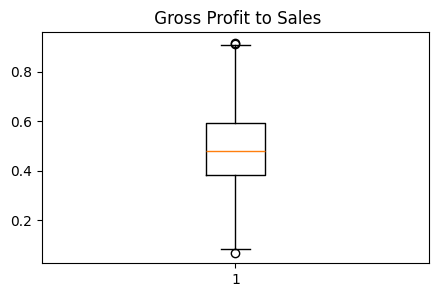

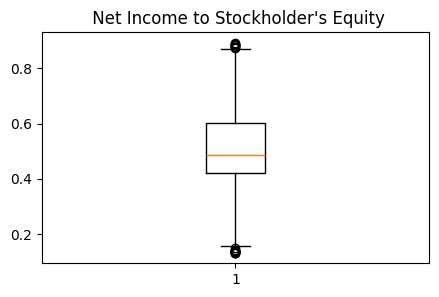

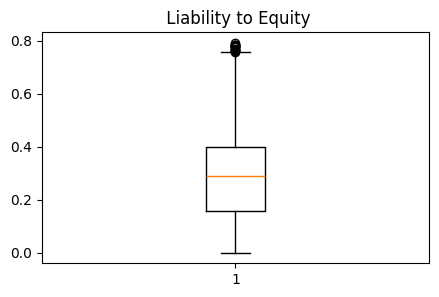

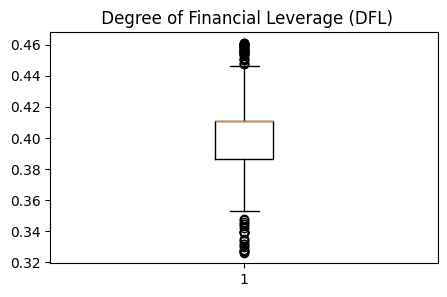

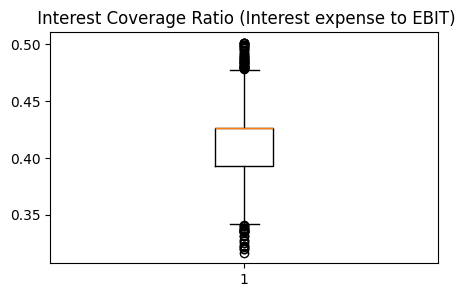

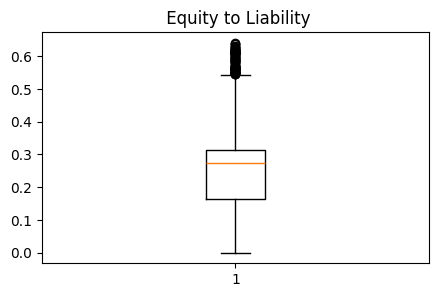

In [168]:
for column in df_x.columns:
    plt.figure(figsize=(5, 3))  # Rozmiar każdego wykresu
    plt.boxplot(df_x[column])  # Rysowanie wykresu pudełkowego dla konkretnej zmiennej
    plt.title(column)  # Tytuł wykresu
    plt.show()

In [169]:
df_x = normalize_data(df_x)
x_train = normalize_data(x_train)

In [170]:
df_x

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.543955,0.570654,0.565974,0.496773,0.499045,0.508415,0.425628,0.425623,0.310646,0.439971,...,0.574289,0.528444,0.094227,0.239070,0.496826,0.599703,0.822736,0.627487,0.596182,0.192511
1,0.867731,0.795085,0.953574,0.511884,0.517834,0.989824,0.888281,0.985202,0.671902,0.948239,...,0.723621,0.733458,0.408611,0.375687,0.511953,0.679853,0.327324,0.627487,0.878084,0.480833
2,0.481877,0.476690,0.479536,0.483787,0.489092,0.476125,0.467643,0.460280,0.942408,0.460820,...,0.158316,0.475561,0.080108,0.730915,0.483812,0.466172,0.126786,0.459721,0.434933,0.429827
3,0.614552,0.634261,0.595296,0.394144,0.397293,0.489628,0.512556,0.514798,0.865620,0.484184,...,0.317681,0.626508,0.408907,0.855522,0.394106,0.575416,0.290462,0.627487,0.596182,0.540092
4,0.481877,0.476690,0.479536,0.748150,0.756847,0.476125,0.467643,0.460280,0.492147,0.460820,...,0.453089,0.947587,0.408907,0.401263,0.748134,0.466172,0.613335,0.754193,0.637002,0.258603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,0.355694,0.310806,0.346671,0.327719,0.331529,0.100196,0.279137,0.267134,0.499127,0.294752,...,0.425194,0.312853,0.111978,0.238560,0.327717,0.310798,0.239440,0.627487,0.596182,0.650827
1428,0.383825,0.430069,0.385767,0.234377,0.239013,0.309589,0.605280,0.607866,0.499127,0.607477,...,0.373945,0.497036,0.408907,0.483323,0.234445,0.444768,0.165609,0.402003,0.394512,0.923976
1429,0.686503,0.652331,0.620342,0.751613,0.752866,0.476125,0.714746,0.635514,0.499127,0.659238,...,0.309067,0.679592,0.177734,0.740870,0.751612,0.615718,0.277339,0.435893,0.418278,0.564837
1430,0.853665,0.709794,0.793219,0.513616,0.519586,0.823483,0.849324,0.858255,0.499127,0.715672,...,0.316088,0.727065,0.408907,0.483323,0.513592,0.599131,0.130564,0.365155,0.368563,0.429827


### From now on, we'll use x_train to train the data and df_x will be used for predictions

### Lasso

ROC AUC score: 0.8943191521422472


C:\Users\sylge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


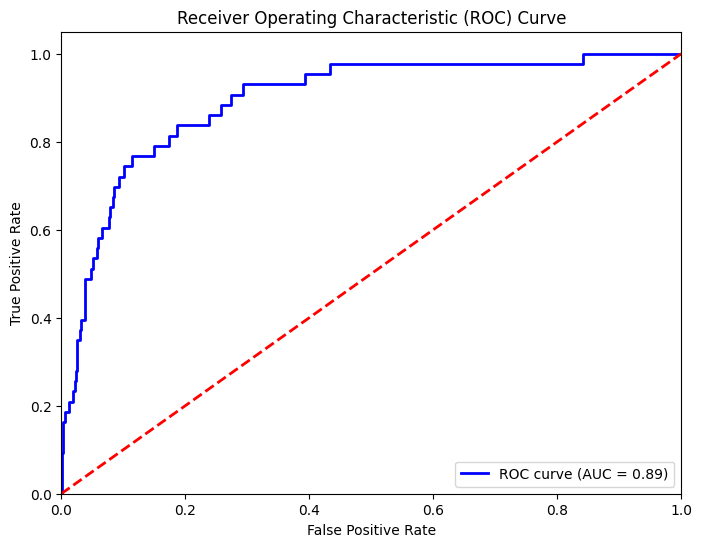

In [171]:
# Standaryzacja danych treningowych
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Standaryzacja danych testowych
x_test_scaled = scaler.transform(df_x)

# Tworzenie modelu regresji LassoCV z standaryzowanymi danymi
lasso_model = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], max_iter=1000, cv=5)
lasso_model.fit(x_train_scaled, y_train)

# Wybieramy najlepszą wartość alpha dla naszych danych
pred = lasso_model.predict(df_x)
calculate_metrics(df_y, pred)

### Logistic Regression

In [172]:
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [173]:
pred = lr_model.predict(df_x)

In [174]:
df_x

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.543955,0.570654,0.565974,0.496773,0.499045,0.508415,0.425628,0.425623,0.310646,0.439971,...,0.574289,0.528444,0.094227,0.239070,0.496826,0.599703,0.822736,0.627487,0.596182,0.192511
1,0.867731,0.795085,0.953574,0.511884,0.517834,0.989824,0.888281,0.985202,0.671902,0.948239,...,0.723621,0.733458,0.408611,0.375687,0.511953,0.679853,0.327324,0.627487,0.878084,0.480833
2,0.481877,0.476690,0.479536,0.483787,0.489092,0.476125,0.467643,0.460280,0.942408,0.460820,...,0.158316,0.475561,0.080108,0.730915,0.483812,0.466172,0.126786,0.459721,0.434933,0.429827
3,0.614552,0.634261,0.595296,0.394144,0.397293,0.489628,0.512556,0.514798,0.865620,0.484184,...,0.317681,0.626508,0.408907,0.855522,0.394106,0.575416,0.290462,0.627487,0.596182,0.540092
4,0.481877,0.476690,0.479536,0.748150,0.756847,0.476125,0.467643,0.460280,0.492147,0.460820,...,0.453089,0.947587,0.408907,0.401263,0.748134,0.466172,0.613335,0.754193,0.637002,0.258603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,0.355694,0.310806,0.346671,0.327719,0.331529,0.100196,0.279137,0.267134,0.499127,0.294752,...,0.425194,0.312853,0.111978,0.238560,0.327717,0.310798,0.239440,0.627487,0.596182,0.650827
1428,0.383825,0.430069,0.385767,0.234377,0.239013,0.309589,0.605280,0.607866,0.499127,0.607477,...,0.373945,0.497036,0.408907,0.483323,0.234445,0.444768,0.165609,0.402003,0.394512,0.923976
1429,0.686503,0.652331,0.620342,0.751613,0.752866,0.476125,0.714746,0.635514,0.499127,0.659238,...,0.309067,0.679592,0.177734,0.740870,0.751612,0.615718,0.277339,0.435893,0.418278,0.564837
1430,0.853665,0.709794,0.793219,0.513616,0.519586,0.823483,0.849324,0.858255,0.499127,0.715672,...,0.316088,0.727065,0.408907,0.483323,0.513592,0.599131,0.130564,0.365155,0.368563,0.429827


ROC AUC score: 0.5788755504210826


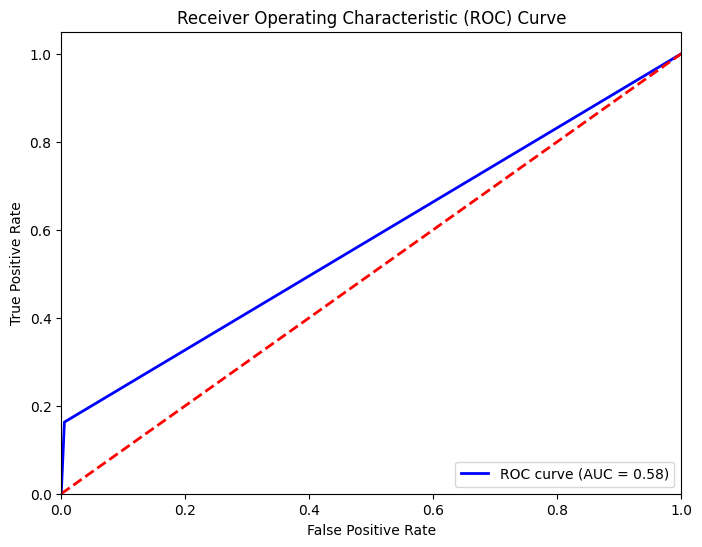

In [175]:
calculate_metrics(df_y, pred)

#zobaczmy co się stanie jak dodamy wagę

In [176]:
lr2_model = LogisticRegression(max_iter=10000, class_weight='balanced')
lr2_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [177]:
pred = lr2_model.predict(df_x)

ROC AUC score: 0.8368911882398246


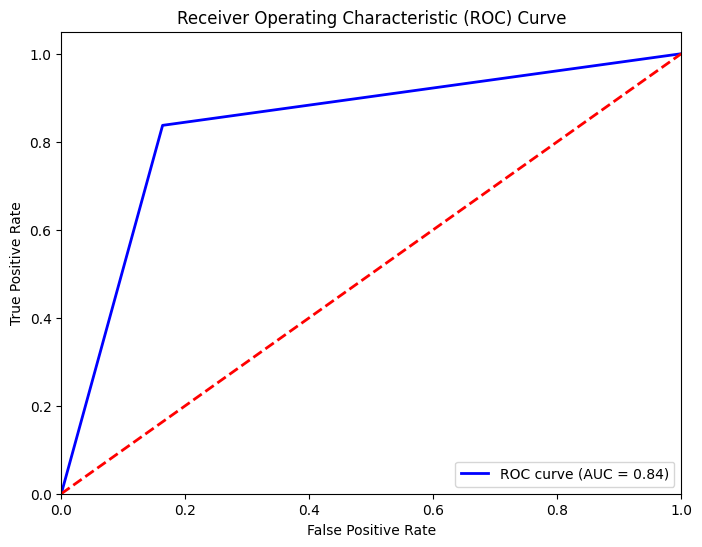

In [178]:
calculate_metrics(df_y, pred)

# DecisionTREE

In [179]:
DT_model = DecisionTreeClassifier() # Create a decision tree classifier object

DT_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [180]:
pred = DT_model.predict(df_x)

ROC AUC score: 0.6779848309809634


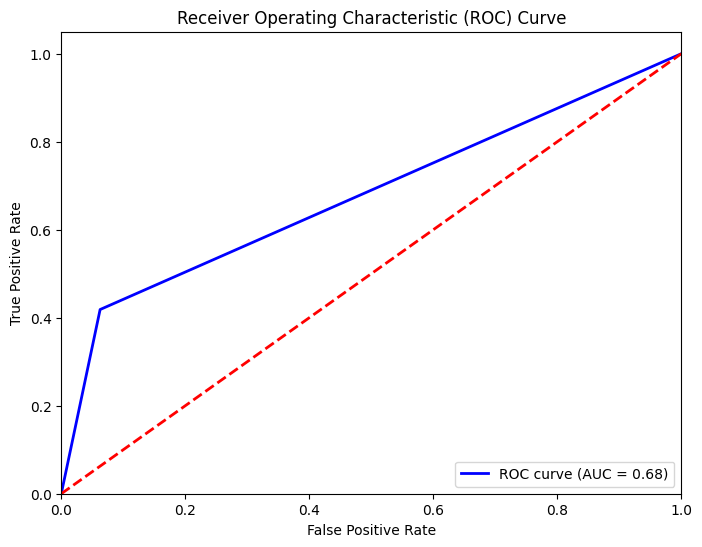

In [181]:
calculate_metrics(df_y, pred)

# Random Forest

In [182]:
RF_model = RandomForestClassifier()

RF_model.fit(x_train, y_train)

predictions = RF_model.predict(df_x)

